# Importer & préparer n'importe quels types de données sur FastAI 

## Ce que vous apprendrez dans ce cours 

Nous avons vu dans le cours précédent comment nous pouvions créer des modèles simples sur des données relativement simples. Cependant, le monde du deep learning n'est pas toujours aussi sympathique. C'est pourquoi, nous souhaitons aller plus en profondeur sur la préparation des données et vous donner les armes pour pouvoir créer vos propres datasets facilement. 

## Rappels : Comment créer des ```DataBunch``` simplement 

Nous avons vu dans le cours précédent que nous avions des ```DataBunch``` préfaits en fonction des scénarios que nous souhaitions attaquer. 

|Scénario|DataBunch|
|--------------|------------------|
|Gestion d'images| ```ImageDataBunch```|
|Classification de textes (analyse de sentiments)|```TextClasDataBunch```|
|Language Modeler (Prédire le prochain mot dans une phrase)| ```TextLMDataBunch```|
|Données tabulaires|```TabularDataBunch```|
|Collaborative Filtering| ```CollabDataBunch```|


Combiné avec les fonctions d'aide suivantes, vous pouviez importer déjà un certain nombre de données pour entrainement 

|Source de données|Methode|
|------------------------------|--------------|
|Des dossiers| ```from_folder()```|
|Des DataFrames| ```from_df()```|
|Des fichiers csv| ```from_csv()```|

In [1]:
from fastai.vision import *
path = untar_data(URLs.MNIST_SAMPLE)
data = ImageDataBunch.from_folder(path)
learn = cnn_learner(data, models.resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [2]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,time
0,0.217547,0.121851,01:14
1,0.119168,0.086426,01:15


Cependant, il peut arriver que vous ne puissiez pas toujours vous en sortir avec les ```DataBunch``` préfaits, c'est pour cela que FastAI a créé un ```DataBlockAPI``` qu'il est important de voir 

## Les éléments nécessaires à la construction d'un DataBunch 

Il y a quatres étapes que vous devez connaitre dans la construction d'un databunch : 

1. Donner les inputs (vos données brutes)
2. Splitter vos données en un train et test set 
3. Labelliser vos données 
4. Appliquer les transformations nécessaire (si besoin)
5. Convertir en DataBunch 

Regardons donc chacune de ces étapes de plus près. 

### Donner les inputs

De la même façon qu'au dessus, vous devrez vous poser la question : quel est la problématiques que j'essaie de résoudre. En fonction, vous pourrez choisir la classe qui correspond à ce que vous faites : 

|Classe|Scénario|
|-----------|-------------|
|CategoryList| for labels in classification|
|MultiCategoryList| for labels in a multi classification problem|
|FloatList| for float labels in a regression problem|
|ImageList| for data that are images|
|SegmentationItemList| like ImageList but will default labels to SegmentationLabelList|
|SegmentationLabelList| for segmentation masks|
|ObjectItemList| like ImageList but will default labels to ObjectLabelList|
|ObjectLabelList| for object detection|
|PointsItemList| for points (of the type ImagePoints)|
|ImageImageList| for image to image tasks|
|TextList| for text data|
|TabularList| for tabular data|
|CollabList| for collaborative filtering|

Toutes ces classes viennent de la classe parente : ```ItemList```

La suite reste la même méthode, vous pouvez utiliser des fonctions d'aide relative à la provenance de votre input :

  |Helper function|Notes|
  |------------------------|----------|
  |from_folder|Pour les données qui viennent de dossiers|
  |from_csv|Pour les données provenant d'un csv|
  |from_df| Pour les données provenant de DataFrame|

In [ ]:
# Exemple sur MNIST
df = pd.read_csv(path/'labels.csv')
data_mnist = ImageList.from_df(df=df, path=path)
data_mnist

ImageList (14434 items)
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
Path: /root/.fastai/data/mnist_sample

In [ ]:
# Exemple sur un IMDB
from fastai.text import *
imdb = untar_data(URLs.IMDB_SAMPLE)

import pandas as pd
text = pd.read_csv(imdb/"texts.csv")

data_imdb = TextList.from_folder(imdb/"texts.csv")
data_imdb

TextList (0 items)

Path: /root/.fastai/data/imdb_sample/texts.csv

### Splitter vos données 

La deuxième étapes est de splitter en données d'entrainement et de test. Pour cela, nous avons aussi une batterie de méthodes qui vont pouvoir nous être utile 

|Méthode|Explication|Exemple|
|--------------|-----------------|-------------|
|```split_by_rand_pct(valid_pct:float=0.2, seed:int=None)```| Split par items|
|```split_subsets(train_size:float, valid_size:float, seed=None)```| Split par sous partie de votre dataset, cela ressemble beaucoup à split_by_rand_pct|
|```split_by_files(valid_names:ItemList)```| Split par noms de fichiers|
|```split_by_fname_file(fname:PathOrStr, path:PathOrStr=None)```| Split par noms de fichiers de la même manière mais prend comme input un Path au lieu d'un ItemList|
|```split_by_folder(train:str='train', valid:str='valid')```|Split par noms de dossiers|
|```split_by_idx(valid_idx:Collection[int])```|Split par numéro d'index|
|```split_by_idxs(train_idx, valid_idx)```|Précise quels indexes vont dans le train et lesquels vont dans le test|
|```split_by_list(train, valid)```|Sépare par listes d'items|
|```split_by_valid_func(func:Callable)```|Sépare par une fonction donnée|
|```split_from_df(col:IntsOrStrs=2)```|Sépare sur des DataFrame données|
|```split_none()```|N'applique pas de split|

In [ ]:
# Exemple sur un DataFrame 

path = untar_data(URLs.MNIST_SAMPLE)
df = pd.read_csv(path/'labels.csv')

# Create a new column for is_valid
df['is_valid'] = [True]*(df.shape[0]//2) + [False]*(df.shape[0]//2)

# Randomly shuffle dataframe
df = df.reindex(np.random.permutation(df.index))
print(df.shape)

data = (ImageList.from_df(df, path)
                 .split_from_df())
data

(14434, 3)


ItemLists;

Train: ImageList (7217 items)
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
Path: /root/.fastai/data/mnist_sample;

Valid: ImageList (7217 items)
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
Path: /root/.fastai/data/mnist_sample;

Test: None

In [ ]:
# Exemple sur un index
path = untar_data(URLs.MNIST_SAMPLE)
df = pd.read_csv(path/'labels.csv')

data = (ImageList.from_df(df, path)
                 .split_by_idx(list(range(1000))))
data

ItemLists;

Train: ImageList (13434 items)
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
Path: /root/.fastai/data/mnist_sample;

Valid: ImageList (1000 items)
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
Path: /root/.fastai/data/mnist_sample;

Test: None

In [ ]:
# Exemple sur un dossier 
path_data = untar_data(URLs.MNIST_TINY)

data = (ImageList.from_folder(path=path_data)
                .split_by_folder(train="train", valid="valid"))
data

ItemLists;

Train: ImageList (709 items)
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
Path: /root/.fastai/data/mnist_tiny;

Valid: ImageList (699 items)
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
Path: /root/.fastai/data/mnist_tiny;

Test: None

### Labelliser vos données 

La prochaine étape est de labelliser vos données. De la même manière qu'au dessus, nous avons plusieurs méthodes possibles 

|Méthode|Explication|
|--------------|------------------|
|```label_from_df(cols:IntsOrStrs=1, label_cls:Callable=None, **kwargs)```|Les labels sont présents dans une colonne de votre DataFrame|
|```label_from_folder(label_cls:Callable=None, **kwargs)```| Les labels viennent d'un dossiers en particulier|
|```label_from_func(func:Callable, label_cls:Callable=None, **kwargs)```| Vous devez labelliser vous même via une fonction|
|```label_from_re(pat:str, full_path:bool=False, label_cls:Callable=None, **kwargs)```|Vous devez labelliser via une expression régulière|


In [ ]:
# Exemple avec label_from_df
path_data = untar_data(URLs.MNIST_TINY)

data = (ImageList.from_df(pd.read_csv(path_data/"labels.csv"), path_data)
                 .split_by_rand_pct(0.2)
                 .label_from_df("label"))

data

LabelLists;

Train: LabelList (1127 items)
x: ImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
3,3,3,3,3
Path: /root/.fastai/data/mnist_tiny;

Valid: LabelList (281 items)
x: ImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
3,7,3,3,3
Path: /root/.fastai/data/mnist_tiny;

Test: None

In [ ]:
### FYI, voici à quoi ressemble le dataFrame
pd.read_csv(path_data/'labels.csv').head()

,name,label
0,train/3/7463.png,3
1,train/3/9829.png,3
2,train/3/7881.png,3
3,train/3/8065.png,3
4,train/3/7046.png,3


In [ ]:
# Exemple avec label_from_folder

## Ici, nous voyons en output les deux dossiers dans lesquels sont présents des images de 3 et de 7
train = path_data/"train"
train.ls()

[PosixPath('/root/.fastai/data/mnist_tiny/train/3'),
 PosixPath('/root/.fastai/data/mnist_tiny/train/7')]

In [ ]:
## On peut donc utiliser label_from_folder qui comprendra de lui-même quels sont les bons labels 
path_data = untar_data(URLs.MNIST_TINY)
data = (ImageList.from_folder(path_data)
                 .split_by_folder('train', 'valid')
                 .label_from_folder())
data

LabelLists;

Train: LabelList (709 items)
x: ImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
3,3,3,3,3
Path: /root/.fastai/data/mnist_tiny;

Valid: LabelList (699 items)
x: ImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
3,3,3,3,3
Path: /root/.fastai/data/mnist_tiny;

Test: None

### Appliquer les transformations nécessaires 

Notre DataBunch est presque prêt. Il manque quelque chose d'important, particulièrement lors du traitement d'image : la *data augmentation*. Ce principe est simplement d'appliquer des transformations mineures aux images pour que le modèle s'entraine sur des éléments qui ne soient pas exactement pareils à chaque epoch. 

#### ```get_transform()```

La méthode que l'on utilisera le plus souvent est ```get_transform()``` qui s'occupera de faire tout le travail compliqué pour nous. Globalement, ce qu'elle fait est de changer les images de manière très incrémentales. Cela peut se matérialiser de plusieurs façons : 

* Changer l'orientation de l'image 
* Zoomer sur l'image 
* Retourner l'image
* Changer la luminosité 
* ...

Nous utiliserons cette fonction en plus de la méthode ```.transform()``` pour notre DataBunch 



In [ ]:
path_data = untar_data(URLs.MNIST_TINY)
data = (ImageList.from_folder(path_data)
                 .split_by_folder('train', 'valid')
                 .label_from_folder()
                 .transform(get_transforms(flip_vert=True)))
data

LabelLists;

Train: LabelList (709 items)
x: ImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
3,3,3,3,3
Path: /root/.fastai/data/mnist_tiny;

Valid: LabelList (699 items)
x: ImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
3,3,3,3,3
Path: /root/.fastai/data/mnist_tiny;

Test: None

N'hésitez pas à regarder en détail la documentation sur [get_transform](https://docs.fast.ai/vision.transform.html#get_transforms) et les possibilités qui s'offrent vous.

### Transformer en DataBunch 

On peut enfin transformer nos données en DataBunch, pour cela rien de plus simple. Il vous suffira d'ajouter : ```.databunch()```

In [ ]:
path_data = untar_data(URLs.MNIST_TINY)
data = (ImageList.from_folder(path_data)
                 .split_by_folder('train', 'valid')
                 .label_from_folder()
                 .transform(get_transforms(flip_vert=True))
                 .databunch())

Vous disposez maintenant de tout un arsenal de méthode pour regarder votre ```databunch```

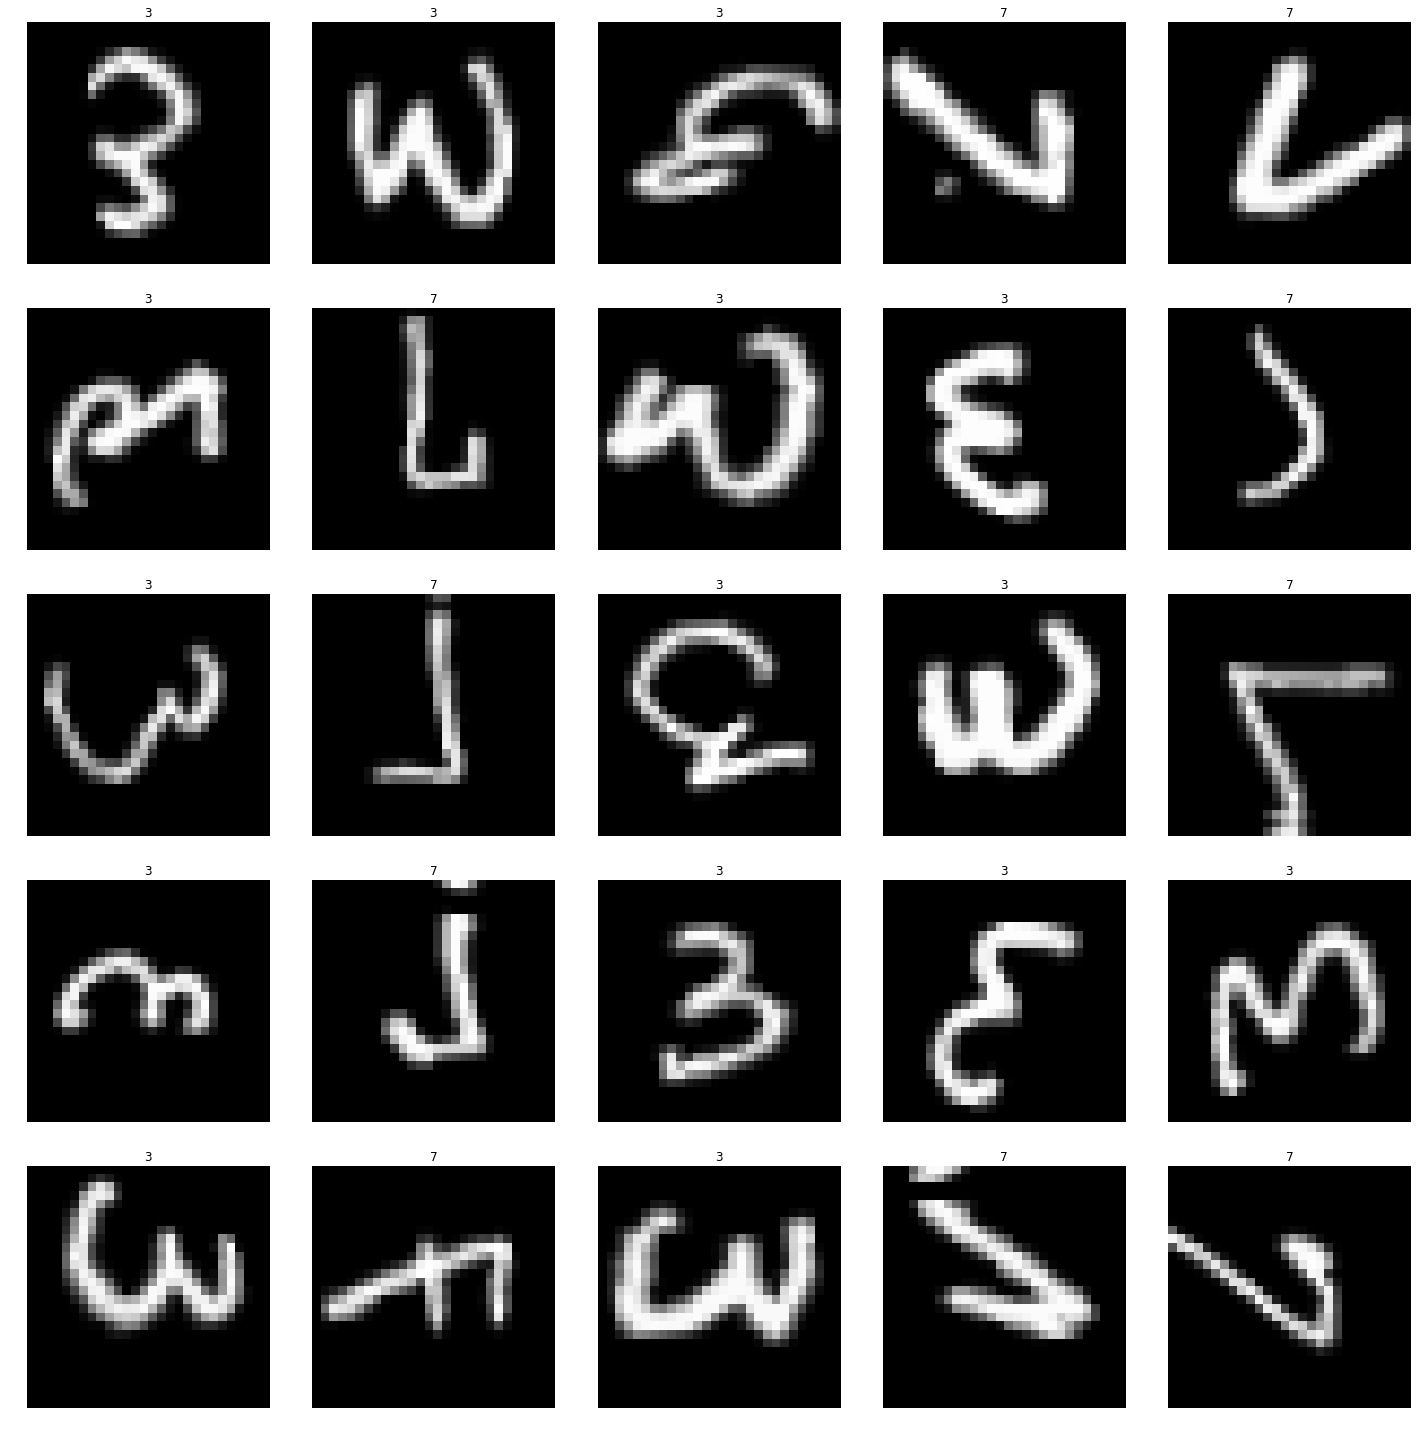

In [ ]:
# Vous permet de regarder une partie de vos données 
data.show_batch()

In [ ]:
# Vous permet de connaitre la taille de chacun des batchs qui iront à l'entrainement de chaque epoch.
data.batch_size

64

In [ ]:
# Vous permet d'avoir toutes les informations basiques de votre dataset 
data.batch_stats

<bound method ImageDataBunch.batch_stats of ImageDataBunch;

Train: LabelList (709 items)
x: ImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
3,3,3,3,3
Path: /root/.fastai/data/mnist_tiny;

Valid: LabelList (699 items)
x: ImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
3,3,3,3,3
Path: /root/.fastai/data/mnist_tiny;

Test: None>

## Ressources

* [Data Block de FastAI](https://docs.fast.ai/data_block.html)
* [Transformations with FastAI](https://docs.fast.ai/vision.transform.html#List-of-transforms)